## Import

In [32]:
pip install feature_engine

Note: you may need to restart the kernel to use updated packages.


In [33]:
import numpy as np
import time
import json

import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 93)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from feature_engine.selection import SmartCorrelatedSelection


import warnings

# Отключить все предупреждения временно
warnings.filterwarnings("ignore")

# Ваш код, вызывающий предупреждение о переполнении

# Включить предупреждения обратно
# warnings.filterwarnings("default")

In [12]:
train_df = pd.read_parquet("../data/raw/train_data.pqt")
test_df = pd.read_parquet("../data/raw/test_data.pqt")


cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year",
]


train_df[cat_cols] = train_df[cat_cols].astype("category")
test_df[cat_cols] = test_df[cat_cols].astype("category")

df = pd.concat([train_df, test_df], ignore_index=True)
df_low = df[:3000]

## Func

In [34]:
def get_df_low(code: int):
    train_df = pd.read_parquet(f"../data/interim/train_data_lm_{code}.pqt")
    test_df = pd.read_parquet(f"../data/interim/test_data_lm_{code}.pqt")

    cat_cols = [
        "channel_code", "city", "city_type",
        "okved", "segment", "start_cluster",
        "index_city_code", "ogrn_month", "ogrn_year",
    ]

    train_df[cat_cols] = train_df[cat_cols].astype("category")
    test_df[cat_cols] = test_df[cat_cols].astype("category")

    df = pd.concat([train_df, test_df], ignore_index=True)
    return df


def get_feature_description():
  # import feature_description to merge description
  feature_description = pd.read_excel("../data/feature_description.xlsx")
  feature_description.columns = ['col_name', 'description', 'type']
  return feature_description


def cat_column_summary(df):
    """Для категорий всех столбцов"""
    df = df.select_dtypes(exclude="number")
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(
                10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(
                top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })

    summary_df = pd.DataFrame(summary_data)
    summary_df_with_fd = pd.merge(
        summary_df, feature_description, on='col_name', suffixes=('_left', '_right'), how='left')

    return summary_df_with_fd


def num_column_summary(df):
    """Для численных всех столбцов"""

    df = df.select_dtypes(include="number")
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        mean = df[col_name].mean()
        std = df[col_name].std()
        min_val = df[col_name].min()
        q25 = df[col_name].quantile(0.25)
        q50 = df[col_name].quantile(0.50)
        q75 = df[col_name].quantile(0.75)
        max_val = df[col_name].max()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(
                10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(
                top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'mean': mean,
            'std': std,
            'min': min_val,
            'q25': q25,
            'q50': q50,
            'q75': q75,
            'max': max_val,
            'distinct_values_counts': distinct_values_counts

        })

    summary_df = pd.DataFrame(summary_data)
    summary_df_with_fd = pd.merge(
        summary_df, feature_description, on='col_name', suffixes=('_left', '_right'), how='left')

    return summary_df_with_fd
# Пустые значения


def get_nan_3_month_df(df):

  nan_3_month_df = pd.DataFrame(df['id'].unique(), columns=['id'])

  for column in df.columns[1:]:
    start_time = time.time()
    result = df.groupby('id')[column].apply(
        lambda x: x.isna().all()).reset_index()
    nan_3_month_df = pd.merge(
        nan_3_month_df, result, on='id', suffixes=('_left', '_right'), how='left')
    end_time = time.time()
  return nan_3_month_df


def process_nan(x):
    try:
        x = x.dropna(
        ).values[-1] if x.isna().any() and not x.isna().all() else np.nan
        return x
    except:
        print(x)
        return x


def get_nan_values_3_month_df(df):

  nan_3_month_df = pd.DataFrame(df['id'].unique(), columns=['id'])
  for column in df.columns[1:]:
    start_time = time.time()
    result = df.groupby('id')[column].apply(
        lambda x: process_nan(x)).reset_index()
    nan_3_month_df = pd.merge(
        nan_3_month_df, result, on='id', how='left')
    end_time = time.time()
    print(f"{column} {end_time - start_time}")
  return nan_3_month_df


def plt_null_df(df):

    plt.figure(figsize=(15, 8))

    plt.imshow(df, aspect="auto", interpolation="nearest", cmap="viridis")

    plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')

    plt.xlabel("Column Number")
    plt.ylabel("Sample Number")

    plt.show()


# Корреляция
def plt_corr_df(df):

  corr_df = df.select_dtypes(include='number').corr().abs()

  plt.figure(figsize=(20, 15))
  dataplot = sns.heatmap(corr_df,
                         cmap="YlGnBu", annot=True, fmt=".1f",
                         annot_kws={'size': 5})
  plt.show()


def get_columns_corr(df, p: int):
    corr_df = df.select_dtypes(include='number').corr().abs()
    c1 = corr_df.unstack()

    c1_sorted = c1.sort_values(ascending=True)
    columns_above = {(col1, col2): c1_sorted[col1, col2] for col1,
                     col2 in c1_sorted.index if c1_sorted[col1, col2] > p and col1 != col2}

    return dict(sorted(columns_above.items(), key=lambda item: item[1], reverse=True))

In [13]:
def restore_num(x):
  if len(x) != 3:
    return x

  # 3 nan
  if x.isna().sum() == 3:
    v1 = mean_of_col + np.random.uniform(-var_of_col, var_of_col)
    v2 = v1 * (1 + aver_diff)
    v3 = v1 * (1 + aver_diff) * (1+aver_diff)
    x.iloc[0] = v1
    x.iloc[1] = v2
    x.iloc[2] = v3
    return x

  # 2 Nan
  elif x.isna().sum() == 2:
    # month_1 - num
    if not np.isnan(x.iloc[0]):

      v1 = x.iloc[0]

      x.iloc[1] = v1 * (1+aver_diff)
      x.iloc[2] = v1 * (1+aver_diff) * (1+aver_diff)

      return x

    # month_2 - num
    if not np.isnan(x.iloc[1]):

      v1 = x.iloc[1]
      x.iloc[0] = v1 / (1 + aver_diff)
      x.iloc[2] = v1 * (1+aver_diff) * (1+aver_diff)

      return x

    # month_3 - num
    if not np.isnan(x.iloc[2]):
      v1 = x.iloc[2]
      x.iloc[0] = v1 / (1 + aver_diff) / (1 + aver_diff)
      x.iloc[1] = v1 / (1 + aver_diff)

      return x

  # 1 Nan
  elif x.isna().sum() == 1:

    # month_1 - Nan
    if np.isnan(x.iloc[0]):
      v1 = x.dropna().iloc[0]
      v2 = x.dropna().iloc[-1]
      x = x.fillna(v1 * (v1/v2))
      return x

    # month_2 - Nan
    if np.isnan(x.iloc[1]):
      v1 = x.dropna().iloc[0]
      v2 = x.dropna().iloc[-1]
      x = x.fillna((v1 + v2)/2)

      return x

    # month_3 - Nan
    if np.isnan(x.iloc[2]):
      v1 = x.dropna().iloc[0]
      v2 = x.dropna().iloc[-1]
      x = x.fillna(v2 * (v2/v1))
      return x

  else:

    return x


def restore_cal(x):
    if x.isna().any() and not x.isna().all():
      return x.fillna(x.dropna().iloc[-1])
    return x

##  Class Dataset

In [35]:
class Dataset():
    def __init__(self):
        self.train_df = pd.read_parquet("../data/raw/train_data.pqt")
        self.test_df = pd.read_parquet("../data/raw/test_data.pqt")

        cat_cols = [
            "channel_code", "city", "city_type",
            "okved", "segment", "start_cluster",
            "index_city_code", "ogrn_month", "ogrn_year",
        ]


        self.train_df[cat_cols] = self.train_df[cat_cols].astype("category")
        self.test_df[cat_cols] = self.test_df[cat_cols].astype("category")

        self.restored_cat_df = pd.read_parquet("../data/akm/restored_cat_df.pqt")
        self.df = pd.read_parquet("../data/akm/full_data.pqt")
        self.df_after_eda = pd.read_parquet("../data/akm/df_after_eda.pqt")



    def get_df(self):
        return self.df

    def get_train_df(self):
        return self.train_df

    def get_test_df(self):
        return self.test_df

    def get_restored_cat_df(self):
        return self.restored_cat_df

    def get_restored_cat_df(self):
        return self.restored_cat_df

    def get_df_after_eda(self):
        return self.df_after_eda


    def get_df_low(code: int):
        train_df = pd.read_parquet(f"../data/interim/train_data_lm_{code}.pqt")
        test_df = pd.read_parquet(f"../data/interim/test_data_lm_{code}.pqt")

        cat_cols = [
            "channel_code", "city", "city_type",
            "okved", "segment", "start_cluster",
            "index_city_code", "ogrn_month", "ogrn_year",
        ]

        train_df[cat_cols] = train_df[cat_cols].astype("category")
        test_df[cat_cols] = test_df[cat_cols].astype("category")

        df = pd.concat([train_df, test_df], ignore_index=True)
        return df


dataset = Dataset()

df = dataset.get_df_after_eda()

train_df = dataset.get_train_df()
test_df = dataset.get_test_df()


# restored_cat_df = dataset.get_restored_cat_df()

# Feature engineering

#### Удаление плохих столбцов

In [ ]:
####

#### Удаление плохих клиентов из test

### Handaling missing values

#### ✅ Восстановление категориальных данных

Восстановление, где есть хотя бы одно известное значение

In [30]:
restored_cat_df = df.copy()

for column in restored_cat_df.select_dtypes(exclude='number').columns:
  restored_cat_df[column] = restored_cat_df.groupby('id')[column].apply(lambda x: restore_cal(x)).reset_index()[column]

In [38]:
restored_cat_df.to_parquet("../data/akm/restored_cat_df.pqt")

In [44]:
restored_cat_df.select_dtypes(exclude='number').isna()['index_city_code'] == True

0         False
1         False
2         False
3          True
4          True
          ...  
890115    False
890116    False
890117    False
890118    False
890119    False
Name: index_city_code, Length: 890120, dtype: bool

In [45]:
restored_cat_df.head(10)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.7448,0.7055,1.2872,0.7481,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9512,0.5687,0.8976,0.5536,0.7744,0.9365,0.2960,0.9679,"{α, γ}",{other}
1,0,month_2,1.0496,0.8319,2.4586,1.0538,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9488,0.4997,0.7850,0.5519,0.6966,0.9902,0.2989,0.9460,"{α, γ}",{other}
2,0,month_3,0.6927,0.7403,0.4300,0.6957,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9465,0.4422,0.8770,0.5510,0.6632,0.8101,0.2948,0.9570,"{α, γ}",{other}
3,1,month_1,-0.0816,-0.0919,-0.1140,-0.0809,channel_code_2,city_14,city_type_0,NaN,...,0.9453,0.4078,0.3693,0.5671,0.7855,-0.1840,0.2535,0.4625,{other},{other}
4,1,month_2,-0.0950,-0.1005,-0.1193,-0.0943,channel_code_2,city_14,city_type_0,NaN,...,0.9461,0.4308,0.0673,0.5599,0.6966,-0.1839,0.2555,0.4954,{other},{other}
5,1,month_3,-0.0906,-0.1143,-0.1141,-0.0899,channel_code_2,city_14,city_type_0,NaN,...,0.9480,0.4882,0.0432,0.5608,0.7077,-0.1679,0.2590,0.6053,{other},{other}
6,2,month_1,-0.1547,-0.1868,-0.1228,-0.1542,channel_code_12,city_613,city_type_306,NaN,...,0.9445,0.3848,-0.1656,0.5469,0.4077,-0.1787,0.2527,0.4405,{α},{α}
7,2,month_2,-0.1528,-0.1937,-0.1228,-0.1523,channel_code_12,city_613,city_type_306,NaN,...,0.9445,0.3848,-0.1656,0.5469,0.4077,-0.1779,0.2527,0.4405,{α},{α}
8,2,month_3,-0.1487,-0.1870,-0.1124,-0.1482,channel_code_12,city_613,city_type_306,NaN,...,0.9445,0.3848,-0.1656,0.5469,0.4077,-0.1763,0.2524,0.4295,{α},{α}
9,3,month_1,-0.1566,-0.2049,-0.1257,-0.1562,channel_code_14,city_21,city_type_0,index_city_code_46,...,0.9445,0.3848,-0.1656,0.5469,0.4077,-0.2011,0.2509,0.3745,{α},{α}


#### Восстановление числовых данных

In [ ]:
df[:1000].groupby('id')['balance_amt_min'].pct_change().mean() - 1

-1.1836496491861426

In [ ]:
df['balance_amt_min'].value_counts().sort_index()

balance_amt_min
-0.1260    128140
-0.1260      1128
-0.1260       711
-0.1260       541
-0.1260       520
            ...  
88.6380         1
90.5838         1
91.2464         1
91.4491         1
91.4508         1
Name: count, Length: 382491, dtype: int64

In [ ]:
df[:21].groupby('id')['balance_amt_min'].apply(lambda x: restore_num(x)).reset_index()['balance_amt_min']

0     1.2872
1     2.4586
2     0.4300
3    -0.1140
4    -0.1193
5    -0.1141
6    -0.1228
7    -0.1228
8    -0.1124
9    -0.1257
10   -0.1260
11   -0.1258
12   -0.1256
13   -0.1087
14   -0.1257
15    0.8953
16   -0.9356
17    0.9776
18   -0.1053
19    0.1025
20   -0.1249
Name: balance_amt_min, dtype: float64

In [ ]:
start_time = time.time()

mean_of_col = df['balance_amt_min'].mean()
var_of_col = df['balance_amt_min'].var()


aver_diff = df.groupby('id')['balance_amt_min'].pct_change().mean() - 1



df['balance_amt_min'] = df.groupby('id')['balance_amt_min'].apply(lambda x: restore_num(x)).reset_index()['balance_amt_min']

end_time = time.time()


In [ ]:
for column in df.select_dtypes(include = 'number').columns[1:]:

  start_time = time.time()

  mean_of_col = df[column].mean()
  var_of_col = df[column].var()


  aver_diff = df.groupby('id')[column].pct_change().mean() - 1



  df[column] = df.groupby('id')[column].apply(lambda x: restore_num(x)).reset_index()[column]

  end_time = time.time()

  print(f'{column} обработан за {end_time - start_time}')

balance_amt_avg обработан за 100.88029456138611
balance_amt_max обработан за 97.66140127182007
balance_amt_min обработан за 114.36498045921326


KeyboardInterrupt: 

Проверка

In [ ]:
df

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.7448,0.7055,1.2872,0.7481,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9512,0.5687,0.8976,0.5536,0.7744,0.9365,0.2960,0.9679,"{α, γ}",{other}
1,0,month_2,1.0496,0.8319,2.4586,1.0538,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9488,0.4997,0.7850,0.5519,0.6966,0.9902,0.2989,0.9460,"{α, γ}",{other}
2,0,month_3,0.6927,0.7403,0.4300,0.6957,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9465,0.4422,0.8770,0.5510,0.6632,0.8101,0.2948,0.9570,"{α, γ}",{other}
3,1,month_1,-0.0816,-0.0919,-0.1140,-0.0809,channel_code_2,city_14,city_type_0,NaN,...,0.9453,0.4078,0.3693,0.5671,0.7855,-0.1840,0.2535,0.4625,{other},{other}
4,1,month_2,-0.0950,-0.1005,-0.1193,-0.0943,channel_code_2,city_14,city_type_0,NaN,...,0.9461,0.4308,0.0673,0.5599,0.6966,-0.1839,0.2555,0.4954,{other},{other}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890115,299998,month_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.1656,NaN,NaN,-0.2011,NaN,NaN,{},NaN
890116,299998,month_6,-0.1553,-0.2037,-0.1260,-0.1560,channel_code_9,city_25,city_type_0,index_city_code_30,...,0.9445,0.3848,-0.1656,0.5469,0.4077,-0.2011,0.2509,0.3745,NaN,NaN
890117,299999,month_4,-0.1459,-0.1733,-0.1260,-0.1454,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.9445,0.3848,-0.0976,0.5509,0.5744,-0.1014,0.2527,0.4405,{α},NaN
890118,299999,month_5,-0.1364,-0.1639,-0.1215,-0.1359,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.9445,0.3848,-0.0479,0.5551,0.6966,-0.0349,0.2535,0.4734,{α},NaN


In [ ]:
check_df = pd.read_parquet("/content/train_df_checkpoint_8.parquet")
check_df


,id,date,balance_amt_avg,balance_amt_min,channel_code,city,city_type,index_city_code,ogrn_days_end_month,ogrn_days_end_quarter,...,cnt_deb_h_oper_1m,cnt_days_deb_h_oper_1m,sum_cred_h_oper_1m,cnt_cred_h_oper_1m,cnt_days_cred_h_oper_1m,cnt_b_oper_3m,sum_deb_e_oper_3m,sum_deb_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.7448,1.2872,channel_code_5,city_23,city_type_0,index_city_code_39,-0.4886,-0.1351,...,0.6541,0.3879,1.1710,0.6489,0.6616,0.5173,0.3566,0.8976,"{α, γ}",{other}
1,0,month_2,1.0496,2.4586,channel_code_5,city_23,city_type_0,index_city_code_39,-0.4886,-0.1351,...,0.6528,0.2588,0.4104,0.6335,0.5649,0.5173,0.3022,0.7850,"{α, γ}",{other}
2,0,month_3,0.6927,0.4300,channel_code_5,city_23,city_type_0,index_city_code_39,-0.4886,-0.1351,...,0.6534,0.3879,0.5528,0.6296,0.6616,0.5173,0.3468,0.8770,"{α, γ}",{other}
3,1,month_1,-0.0816,-0.1140,channel_code_2,city_14,city_type_0,index_city_code_157,0.3243,1.2587,...,0.6611,0.4201,-0.1710,0.5891,0.0810,0.5173,0.1915,0.3693,{other},{other}
4,1,month_2,-0.0950,-0.1193,channel_code_2,city_14,city_type_0,index_city_code_157,0.3243,1.2587,...,0.6580,0.3556,-0.1307,0.6007,0.3390,0.5173,0.0685,0.0673,{other},{other}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,199998,month_2,-0.1568,-0.1260,channel_code_9,city_14,city_type_0,index_city_code_77,0.3243,-1.0643,...,NaN,0.0933,-0.1718,NaN,NaN,NaN,-0.1530,-0.1656,{},{}
599996,199998,month_3,-0.1568,-0.1260,channel_code_9,city_14,city_type_0,index_city_code_77,0.3243,-1.0643,...,0.6504,0.0975,-0.1718,0.5881,0.0487,0.5173,-0.1530,-0.1656,{α},{}
599997,199999,month_1,-0.1567,-0.1258,channel_code_14,city_1876,city_type_0,index_city_code_195,1.7179,1.7621,...,NaN,0.1843,-0.1718,NaN,NaN,NaN,-0.1530,-0.1656,{},{}
599998,199999,month_2,-0.1567,-0.1258,channel_code_14,city_1876,city_type_0,index_city_code_195,1.7179,1.7621,...,NaN,0.1925,-0.1718,NaN,NaN,NaN,-0.1530,-0.1656,{},{}


In [ ]:
####

#### Проверка

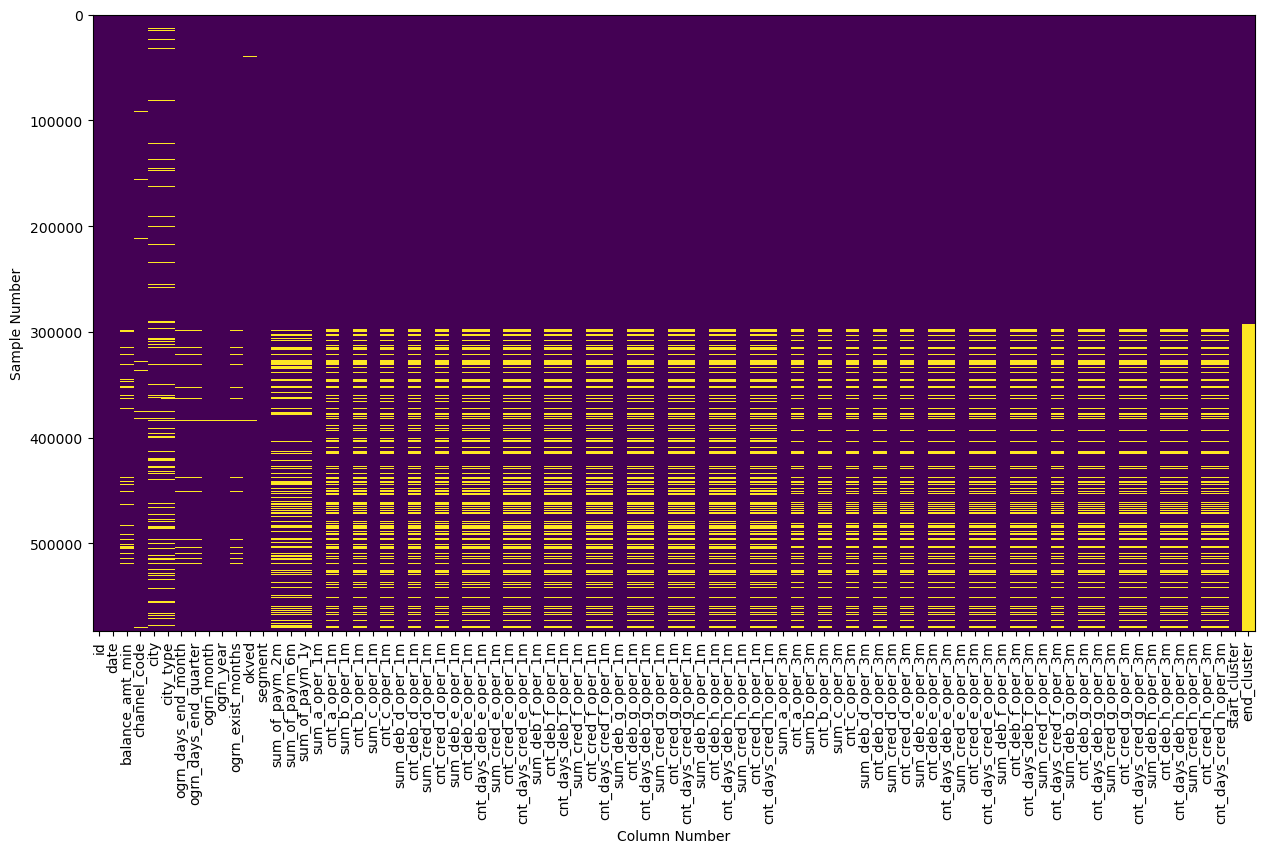

In [36]:
plt_null_df(df.isna())

In [39]:
df.groupby('id')['balance_amt_min'].apply(lambda x: x.isna().all()).value_counts()

balance_amt_min
False    193058
True       4382
Name: count, dtype: int64

In [17]:
df.columns

Index(['id', 'date', 'balance_amt_min', 'channel_code', 'city', 'city_type',
       'ogrn_days_end_month', 'ogrn_days_end_quarter', 'ogrn_month',
       'ogrn_year', 'ogrn_exist_months', 'okved', 'segment', 'sum_of_paym_2m',
       'sum_of_paym_6m', 'sum_of_paym_1y', 'sum_a_oper_1m', 'cnt_a_oper_1m',
       'sum_b_oper_1m', 'cnt_b_oper_1m', 'sum_c_oper_1m', 'cnt_c_oper_1m',
       'sum_deb_d_oper_1m', 'cnt_deb_d_oper_1m', 'sum_cred_d_oper_1m',
       'cnt_cred_d_oper_1m', 'sum_deb_e_oper_1m', 'cnt_deb_e_oper_1m',
       'cnt_days_deb_e_oper_1m', 'sum_cred_e_oper_1m', 'cnt_cred_e_oper_1m',
       'cnt_days_cred_e_oper_1m', 'sum_deb_f_oper_1m', 'cnt_deb_f_oper_1m',
       'cnt_days_deb_f_oper_1m', 'sum_cred_f_oper_1m', 'cnt_cred_f_oper_1m',
       'cnt_days_cred_f_oper_1m', 'sum_deb_g_oper_1m', 'cnt_deb_g_oper_1m',
       'cnt_days_deb_g_oper_1m', 'sum_cred_g_oper_1m', 'cnt_cred_g_oper_1m',
       'cnt_days_cred_g_oper_1m', 'sum_deb_h_oper_1m', 'cnt_deb_h_oper_1m',
       'cnt_days_deb_h

In [42]:
df[df.duplicated(subset=['cnt_cred_d_oper_1m', 'cnt_deb_f_oper_1m', 'cnt_deb_f_oper_3m'], keep=False) &
   (df['id'] > 199999)][['cnt_cred_d_oper_1m', 'cnt_deb_f_oper_1m', 'cnt_deb_f_oper_3m']].T

,600000,600001,600002,600003,600004,600005,600006,600007,600008,600009,...,890110,890111,890112,890113,890114,890115,890116,890117,890118,890119
cnt_cred_d_oper_1m,0.2220,0.2220,0.2220,NaN,NaN,NaN,0.2220,0.2220,0.2220,NaN,...,0.2220,0.2220,0.2220,0.2220,0.2220,NaN,0.2220,0.2220,0.2220,0.2220
cnt_deb_f_oper_1m,0.7713,0.7713,0.7713,NaN,NaN,NaN,0.7714,0.7714,0.7714,NaN,...,0.7713,0.7713,0.7713,0.7713,0.7713,NaN,0.7713,0.7713,0.7713,0.7713
cnt_deb_f_oper_3m,0.2861,0.2861,0.2861,NaN,NaN,NaN,0.2862,0.2862,0.2862,NaN,...,0.2861,0.2861,0.2861,0.2861,0.2861,NaN,0.2861,0.2861,0.2861,0.2861


In [45]:
columns_with_many_nan = []

# Итерируемся по каждому столбцу DataFrame
for column in df.columns:
    # Подсчитываем количество NaN значений в столбце
    nan_count = df[column].isnull().sum()

    # Если количество NaN значений больше 10000, добавляем столбец в список
    if nan_count > 70000:
        columns_with_many_nan.append(column)

# Выводим список столбцов с большим количеством NaN значений
columns_with_many_nan[:-1]

['sum_of_paym_2m',
 'sum_of_paym_6m',
 'sum_of_paym_1y',
 'cnt_a_oper_1m',
 'cnt_b_oper_1m',
 'cnt_c_oper_1m',
 'cnt_deb_d_oper_1m',
 'cnt_cred_d_oper_1m',
 'cnt_deb_e_oper_1m',
 'cnt_days_deb_e_oper_1m',
 'cnt_cred_e_oper_1m',
 'cnt_days_cred_e_oper_1m',
 'cnt_deb_f_oper_1m',
 'cnt_days_deb_f_oper_1m',
 'cnt_cred_f_oper_1m',
 'cnt_days_cred_f_oper_1m',
 'cnt_deb_g_oper_1m',
 'cnt_days_deb_g_oper_1m',
 'cnt_cred_g_oper_1m',
 'cnt_days_cred_g_oper_1m',
 'cnt_deb_h_oper_1m',
 'cnt_days_deb_h_oper_1m',
 'cnt_cred_h_oper_1m',
 'cnt_days_cred_h_oper_1m',
 'cnt_a_oper_3m',
 'cnt_b_oper_3m',
 'cnt_c_oper_3m',
 'cnt_deb_d_oper_3m',
 'cnt_cred_d_oper_3m',
 'cnt_deb_e_oper_3m',
 'cnt_days_deb_e_oper_3m',
 'cnt_cred_e_oper_3m',
 'cnt_days_cred_e_oper_3m',
 'cnt_deb_f_oper_3m',
 'cnt_days_deb_f_oper_3m',
 'cnt_days_cred_f_oper_3m',
 'cnt_deb_g_oper_3m',
 'cnt_days_deb_g_oper_3m',
 'cnt_cred_g_oper_3m',
 'cnt_days_cred_g_oper_3m',
 'cnt_deb_h_oper_3m',
 'cnt_days_deb_h_oper_3m',
 'cnt_cred_h_oper_3

In [46]:
df = df.drop(columns=columns_with_many_nan[:-1])

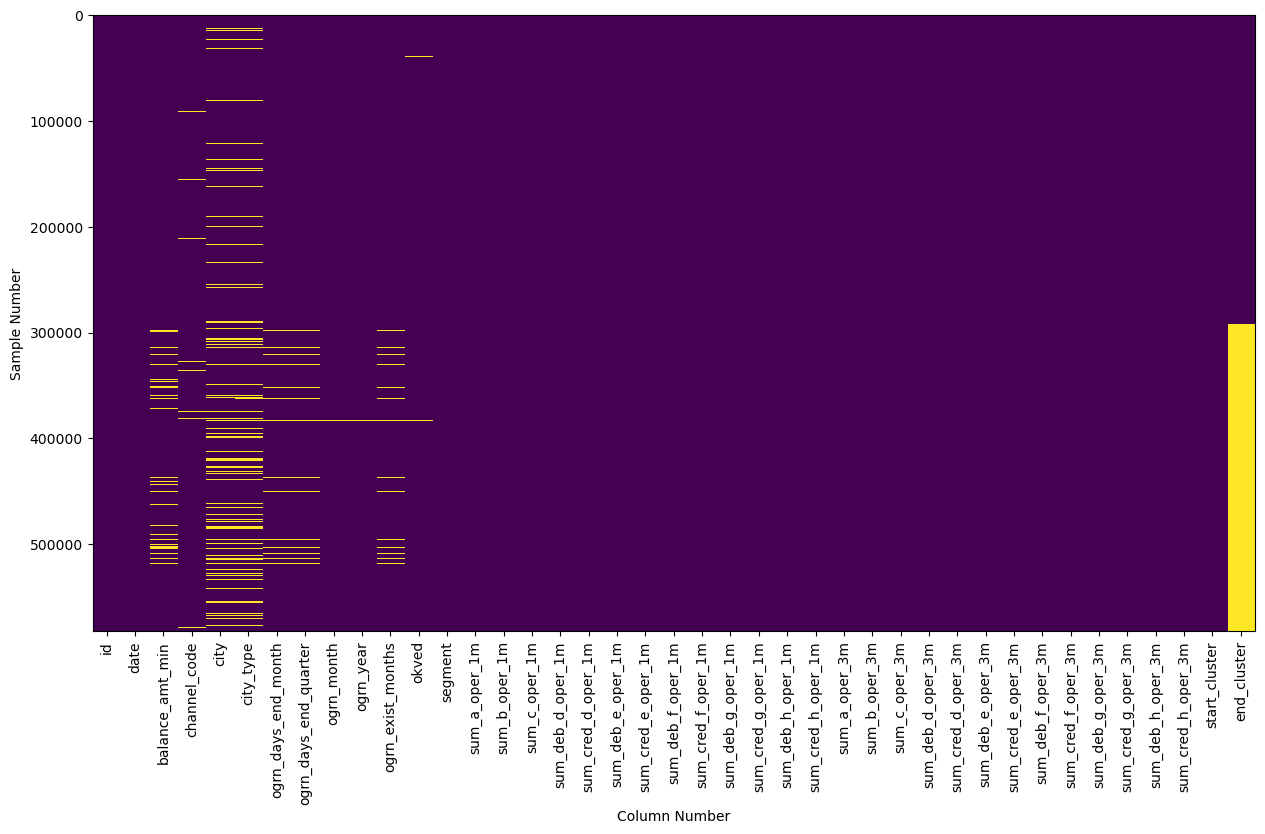

In [47]:
plt_null_df(df.isna())

In [48]:
df.to_parquet("../data/akm/df_afte_fe")